In [21]:
import matplotlib.pylab as plt
import matplotlib as mpl
import numpy as np
import pandas as pd
import time
import sys
import os
import networkx as nx
import re
import scipy.stats

import seaborn as sns
import matplotlib.dates as mdates
from datetime import datetime, date

# preamble for jupyter notebook and django
import django
import platform

if platform.node() == "srv-mcc-apsis":
    sys.path.append("/home/muef/tmv/BasicBrowser/")
    #sys.path.append('/home/leey/tmv/BasicBrowser/')
    dtm_path = "/home/galm/software/dtm/dtm/main"
else:
    # local paths
    sys.path.append('/media/Data/MCC/tmv/BasicBrowser/')
    dtm_path = "/home/finn/dtm/dtm/main"

os.environ.setdefault("DJANGO_SETTINGS_MODULE", "BasicBrowser.settings")
django.setup()

# import from appended path
import parliament.models as pm
import scoping.models as sm
from parliament.tasks import do_search, run_tm, combine_searches
import cities.models as cmodels
from django.contrib.auth.models import User
from tmv_app.models import * 
from utils.tm_mgmt import update_topic_scores
from django.db.models import Q, Count, Func, F, Sum, Avg, Value as V
from django.db.models.functions import TruncDate, TruncMonth, TruncYear

from parliament.utils import merge_utterance_paragraphs

In [3]:
# function definitions for correlations

user1 =  User.objects.get(username='muef')

def dfdt(qs):
    ## Make a queryset of doctopics into a pandas
    ## df in the format we want to used
    df = pd.DataFrame(qs)
    if 'topic_id' not in df.columns:
        df = df.rename(columns={
            'tc': 'score',
            'topic__topicdtopic__dynamictopic_id': 'topic_id'
        })
    return df

def correlate_topics(df, doc_id, method='pearson'):

    df = df.pivot(
        index=doc_id,
        columns='topic_id',
        values='score'
    ).fillna(0)

    corr = df.corr(method=method)
    #values = corr.values
    #cols = corr.columns
    
    if method is 'pearson':
        # calculate p-values for pearson correlation coefficient
        pvalues = calculate_pvalues(df)
    else:
        pvalues = None

    return corr, pvalues
    # end def correlate_topics

# to get p_values:
def calculate_pvalues(df):
    df = df.dropna()._get_numeric_data()
    dfcols = pd.DataFrame(columns=df.columns)
    pvalues = dfcols.transpose().join(dfcols, how='outer')
    for r in df.columns:
        for c in df.columns:
            pvalues[r][c] = scipy.stats.pearsonr(df[r], df[c])[1]
    return pvalues


def filter_occurrence(run_id, dts, filter_occurrence_no, party_name=None, period_list=None):
    stat = RunStats.objects.get(run_id=run_id)
    regular_expression = stat.psearch.text
    SEARCH = re.compile(regular_expression, re.IGNORECASE)

    print("filtering for speeches with {} or more occurrences of\n{}".format(filter_occurrence_no,
                                                                             regular_expression))
    pre_dts_len = len(dts)

    uts = pm.Utterance.objects.filter(search_matches=stat.psearch).order_by('id')
    if party_name:
        uts = uts.filter(speaker__party__name=party_name)
    if period_list:
         uts = uts.filter(document__parlperiod__n__in=period_list)
    
    texts, docsizes, ids = merge_utterance_paragraphs(uts)

    selected_ut_ids = []
    for i, text in enumerate(texts):
        if len(SEARCH.findall(text)) >= filter_occurrence_no:
            selected_ut_ids.append(ids[i])

    dts = dts.filter(ut__id__in=selected_ut_ids)
    print("ids: filtered {} from {}, ratio: {}".format(len(selected_ut_ids), len(ids), len(selected_ut_ids)/len(ids)))
    print("dts: filtered {} from {}, ratio: {}".format(len(dts), pre_dts_len, len(dts)/pre_dts_len))
    
    return dts


# function for calculating a correlation measure based on co-occurrance of most prevalent topics

def event_synchronization(df, doc_id, norm='total', event_threshold=0.1):
    score_sums = df[['ut_id','score']].groupby('ut_id').sum()
    joined_df = df.join(score_sums, on='ut_id', rsuffix='_sum')

    # use threshold of 10 or 5 % of total scores to define event
    joined_df['event'] = (joined_df['score'] > event_threshold * joined_df['score_sum'])

    topics_times_docs = df.ut_id.unique().size * df.topic_id.unique().size
    print("events: {} of {} ({})".format(joined_df['event'].sum(), topics_times_docs, joined_df['event'].sum()/topics_times_docs))
    print("on average {} topics per document".format(joined_df['event'].sum() / df.ut_id.unique().size))
    
    if norm is 'nonzero':
        joined_df['neg_event'] = ~joined_df['event']
        joined_df.neg_event = joined_df.neg_event.astype(int)

        doc_topic_neg_df = joined_df.pivot(
                    index=doc_id,
                    columns='topic_id',
                    values='neg_event'
                    )

    joined_df.event = joined_df.event.astype(int)

    doc_topic_df = joined_df.pivot(
                index=doc_id,
                columns='topic_id',
                values='event'
                )
    
    dot_product = doc_topic_df.transpose().dot(doc_topic_df)
    
    if norm is 'total':
        event_sync = dot_product / df.ut_id.unique().size
    
    elif norm is 'nonzero':
        neg_dot_product = doc_topic_neg_df.transpose().dot(doc_topic_neg_df)
        non_negative_uts = df.ut_id.unique().size - neg_dot_product

        event_sync = dot_product / non_negative_uts
    else:
        print("norm keyword not known")
        return 0
    
    return event_sync

# function for calculating topic correlation
# with slicing by party and/or parliamentary periods

def corr_topics(run_id, party_name=None, period_list=None, filter_occurrence_no=0, method='pearson'):
    print("Calculating topic correlation for party {} and periods {} in run {}".format(party_name, period_list, run_id))
    stat = RunStats.objects.get(pk=run_id)
    s_id = stat.psearch.id

    if stat.psearch is not None:
        doc_id = 'ut_id'
        tars = DynamicTopicTimePeriodScores
    else:
        doc_id = 'doc_id'
        tars = DynamicTopicARScores

    if stat.method=="DT":
        periods = stat.periods.all()
        dts = DocTopic.objects.filter(
            topic__topicdtopic__dynamictopic__run_id=run_id,
            topic__topicdtopic__score__gt=0.05,
            score__gt=0.05
        )
        
        if party_name:
            dts = dts.filter(ut__speaker__party__name=party_name)
        if period_list:
            dts = dts.filter(ut__document__parlperiod__n__in=period_list)
        if filter_occurrence_no:
            dts = filter_occurrence(run_id, dts, filter_occurrence_no,
                                    party_name=party_name, period_list=period_list)
            
        dts = dts.values(
            doc_id,'topic__topicdtopic__dynamictopic_id'
        ).annotate(
            tc=Sum(F('score') * F('topic__topicdtopic__score'),
        )).values(
            doc_id,
            'topic__topicdtopic__dynamictopic_id',
            'tc'
        )

        df = dfdt(list(dts))

        obj = DynamicTopicCorr

    else:
        dts = DocTopic.objects.filter(run_id=run_id)
        if party_name:
            dts = dts.filter(ut__speaker__party__name=party_name)
        if period_list:
            dts = dts.filter(ut__document__parlperiod__n__in=period_list)
        if filter_occurrence_no:
            dts = filter_occurrence(run_id, dts, filter_occurrence_no,
                                    party_name=party_name, period_list=period_list)
            
        dts = dts.values(doc_id,'topic_id','score')
        
        df = dfdt(list(dts))

        tars = TopicARScores
        obj = TopicCorr

        if stat.query:
            periods = scoping.models.AR.objects.all()
        else:
            periods = stat.periods.all()

    #df = df.pivot(index='topic_id',columns='doc_id',values='scaled_score')

    # pseudo code for docwise:
    # There are 96 billion combinations, so need to limit
    # For each doc, compare with docs that have a topic_score > 0 of the
    # Largest topic in the doc.
    #obj.objects.filter(run_id=run_id,ar=ar['n']).delete()
    
    if method in ['pearson', 'spearman']:
        corr, pvalues = correlate_topics(df, doc_id, method=method)
    elif method is 'event_sync':
        corr = event_synchronization(df, doc_id)
        pvalues = 0
    else:
        print("method not available")
        return 0
    
    K = RunStats.objects.get(pk=run_id).K
    uts = pm.Utterance.objects.filter(search_matches__id=s_id)
    if party_name:
        uts = uts.filter(speaker__party__name=party_name)
    
    print("filtered docs * K: {}".format(uts.count() * K))
    print("df shape: {}".format(df.shape))
    
    return corr, pvalues
    
def show_matrix(m, topic_list=None):
    fig, ax = plt.subplots(figsize=(10, 10))
    cax = ax.imshow(m)
    if topic_list:
        plt.xticks(np.arange(len(topic_list)), topic_list, rotation='vertical', fontsize=8)
        plt.yticks(np.arange(len(topic_list)), topic_list, fontsize=8)
    cbar = fig.colorbar(cax)
    plt.show()
    
def get_off_diagonal_elements(array):
    vals = array.astype(np.float)
    np.fill_diagonal(vals, np.nan)
    return vals[~np.isnan(vals)].flatten()
    
def corr_hist(corr, threshold_pct, bins=50, log=False, off_diagonal=True):
    if off_diagonal:
        vals = get_off_diagonal_elements(corr.values)
    else:
        vals = corr.values.flatten()
        
    threshold = np.percentile(vals, threshold_pct)
    print("threshold: {}".format(threshold))
    plt.hist(vals, bins=bins, log=log)
    return threshold


# generate matrices

In [4]:
run_id = 2350

save_dir = './plots/topic_analysis_{}/topic_correlations/'.format(run_id)
if not os.path.isdir(save_dir):
    os.mkdir(save_dir)

In [5]:
# get topic scores per period
dts = DocTopic.objects.filter(run_id=run_id)
topic_period_scores = dts.values('topic__title','ut__document__parlperiod__n').annotate(score = Sum('score'))

df = pd.DataFrame.from_dict(topic_period_scores)
df.columns = ['score', 'topic', 'parlperiod']
df_period_scores = df.pivot(index='parlperiod', columns='topic', values='score')
df_period_scores

# get topic scores per party
topic_period_scores = dts.values('topic__title','ut__speaker__party__name').annotate(score = Sum('score'))

df = pd.DataFrame.from_dict(topic_period_scores)
df.columns = ['score', 'topic', 'party']
df_party_scores = df.pivot(index='party', columns='topic', values='score')
df_party_scores

topic,European Coal and Steel Community,agricultural policy,budget,budget 2,climate protection,coal mining,coal policy & prices,debate government policy,economic policy,economic policy & participation,...,procedural,procedural 2,research & development,reunification,risks of nuclear energy,stop words,structural adjustment,subsidy reduction,tax policy,transport policy
party,,,,,,,,,,,,,,,,,,,,,
NaN,1996.303334,1154.485497,2662.623730,1377.093843,1040.432323,705.481074,2595.012813,725.215314,4354.258574,1241.203541,...,8612.083514,1284.784088,1819.744165,1683.423501,1761.385919,9255.844508,1493.439199,1538.412836,1350.924676,1132.859553
afd,75.727338,16.892710,84.218820,37.884908,1677.816751,0.710000,23.897695,2565.474998,335.120402,43.059506,...,119.692469,20.533711,98.348674,232.816838,246.868783,1580.727233,170.059286,252.880612,231.469484,126.128306
bp,652.347775,0.080000,14.103082,4.848991,1.326530,0.080000,137.410643,0.080000,73.914542,299.387353,...,342.034997,0.080000,0.080000,2.974672,0.080000,281.978064,59.578484,0.080000,2.860608,0.080000
cducsu,52852.691823,28184.476551,83636.980459,43045.346905,24396.418538,23081.588120,42384.725873,12468.288267,95747.893250,29291.145490,...,153504.727782,50885.189117,26401.252905,23514.434376,31744.121727,146119.282769,17746.449382,22049.819565,29120.454911,40199.975003
dp,2681.978035,219.278004,158.401585,5.064760,0.210000,6.328806,460.583522,3.430666,1251.470292,447.010422,...,971.423004,43.106205,92.227988,32.263680,7.738184,1049.911657,123.515487,8.079797,71.018868,188.380337
drp,1330.411104,0.030000,0.030000,0.030000,0.030000,0.030000,16.576617,0.030000,85.196317,27.466161,...,288.832941,0.030000,0.030000,3.393664,0.030000,731.964228,0.030000,0.030000,0.030000,0.030000
dzp,2382.989321,415.370631,461.108061,36.589563,2.613395,88.633873,2161.138312,7.279751,2027.729374,713.074689,...,669.815031,5.492825,21.617248,9.665940,12.339114,1326.105167,80.135743,5.866052,1057.634671,331.745521
fdp,13628.057114,9972.827975,17123.125652,12973.842036,8926.626487,6751.257765,12322.273907,6639.333036,42640.588962,9409.698683,...,65223.030654,18572.122387,6948.788231,7835.333767,7336.047646,66774.255585,6329.964838,16439.008883,9473.509051,8862.505574
fraktionslos,4.296117,0.010000,0.010000,0.010000,67.541040,1.383701,0.010000,0.010000,0.010000,0.010000,...,19.427981,0.010000,0.010000,44.111117,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000


In [23]:
#sns.reset_orig()
sns.set()

def spider_graph(stats, labels, title=None, ax=None, ymax=None):

    angles=np.linspace(0, 2*np.pi, len(labels), endpoint=False)
    # close the plot
    stats=np.concatenate((stats,[stats[0]]))
    angles=np.concatenate((angles,[angles[0]]))

    if not ax:
        fig=plt.figure()
        ax = fig.add_subplot(111, polar=True)
    # If you want the first axis to be on top:
    ax.set_theta_offset(np.pi / 2)
    ax.set_theta_direction(-1)
    
    ax.plot(angles, stats, 'o-', linewidth=2)
    ax.fill(angles, stats, alpha=0.25)
    
    # Draw ylabels
    ax.set_rlabel_position(0)
    if ymax:
        tick_pos = np.arange(0, ymax, 10)
        ax.set_yticks(tick_pos)
        ax.set_yticklabels([str(i) for i in tick_pos], color="grey", size=8)
        ax.set_ylim(0, ymax)

    ax.set_thetagrids(angles * 180/np.pi, labels)
    
    rotate_ticklabels(ax)
    
    if title:
        ax.set_title(title)
    ax.grid(True)

    
def rotate_ticklabels(ax):
    
    plt.gcf().canvas.draw()
    if len(ax.get_xticklabels()) == 5:
        angles = [0, 270, 0, 90]   
    else:
        angles = np.linspace(0,2*np.pi,len(ax.get_xticklabels())+1)
        angles[np.cos(angles) < 0] = angles[np.cos(angles) < 0] + np.pi
        angles = np.rad2deg(angles)
    labels = []
    for label, angle in zip(ax.get_xticklabels(), angles):
        x,y = label.get_position()
        lab = ax.text(x,y, label.get_text(), transform=label.get_transform(),
                      ha=label.get_ha(), va=label.get_va(), fontsize=10)
        lab.set_rotation(angle)
        labels.append(lab)
    ax.set_xticklabels([])

In [ ]:
topic_dir = "plots/topic_analysis_{}/".format(run_id)
topic_classification = pd.read_csv(topic_dir + '0_topic_list_run{}_labeled.csv'.format(run_id), index_col=0)
topic_classification #['classification']

# for parties

Calculating topic correlation for party cducsu and periods [12, 13, 14, 15, 16, 17, 18, 19] in run 2350
events: 4066 of 43995 (0.0924195931355836)
on average 3.2346857597454255 topics per document
filtered docs * K: 112805
df shape: (43995, 3)
cducsu
                            mean sum  total sum  pct mean sum  pct total sum
economy and budget          0.113047   1.130469     22.204860      32.651654
energy                      0.117144   0.937152     23.009610      27.068015
environment                 0.126014   0.630072     24.751934      18.198529
international and regional  0.152904   0.764519     30.033596      22.081801


/home/galm/software/django/tmv/venv/lib/python3.6/site-packages/ipykernel_launcher.py:36: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.


Calculating topic correlation for party fdp and periods [12, 13, 14, 15, 16, 17, 18, 19] in run 2350
events: 2202 of 23590 (0.09334463755828741)
on average 3.2670623145400595 topics per document
filtered docs * K: 51835
df shape: (23590, 3)
fdp
                            mean sum  total sum  pct mean sum  pct total sum
economy and budget          0.149852   1.498516      29.41819      40.725806
energy                      0.127782   1.022255      25.08556      27.782258
environment                 0.115134   0.575668      22.60249      15.645161
international and regional  0.116617   0.583086      22.89376      15.846774
Calculating topic correlation for party gruene and periods [12, 13, 14, 15, 16, 17, 18, 19] in run 2350
events: 2586 of 28455 (0.09088033737480232)
on average 3.180811808118081 topics per document
filtered docs * K: 34405
df shape: (28455, 3)
gruene
                            mean sum  total sum  pct mean sum  pct total sum
economy and budget          0.082780   0.82

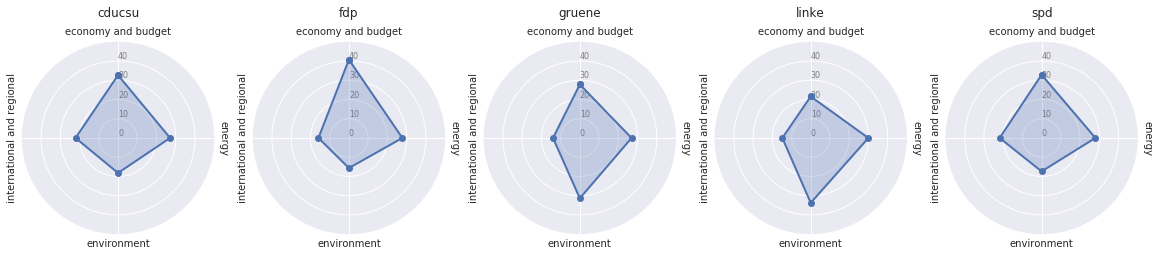

In [30]:
correlation_method = 'event_sync' #'spearman'

new_labels = False
threshold0 = False
percentile = 90
filter_occurrence_no = None
wo_procedural = True

# increase space between axis and title
mpl.rcParams['axes.titlepad'] = 15.

classes = ["economy and budget", "energy", "environment", "international and regional"]
parties = ["cducsu", "fdp", "gruene", "linke", "spd"]

fig, axs = plt.subplots(1, len(parties), subplot_kw=dict(polar=True), figsize=(4*len(parties),4))

for i, party_name in enumerate(parties):

    corr, pvalues = corr_topics(run_id,
                                party_name=party_name,
                                period_list=[12, 13, 14, 15, 16, 17, 18, 19],
                                filter_occurrence_no=filter_occurrence_no,
                                method=correlation_method)
    # start from 1990, i.e. 12th parliamentary period
    
    if wo_procedural:
        topic_dir = "plots/topic_analysis_{}/".format(run_id)
        topic_classification = pd.read_csv(topic_dir + '0_topic_list_run{}_labeled.csv'.format(run_id), index_col=0)
        procedural_topic_ids = topic_classification[topic_classification['classification'] == 'procedural and general politics'].index
        procedural_topic_ids

        corr = corr.drop(procedural_topic_ids, axis=0)
        corr = corr.drop(procedural_topic_ids, axis=1)
    
    # set diagonal elements to zero
    corr.values[[np.arange(corr.shape[0])]*2] = 0
    #show_matrix(corr)
    
    centrality_measures = ['mean sum', 'total sum']
    centrality_sums = pd.DataFrame(0, columns=centrality_measures, index=classes)
    
    for cl in classes:
        topic_info = topic_classification[topic_classification['classification'] == cl]
        topic_labels = topic_info['label'].values
        topic_ids = topic_info.index
        
        centrality_sums.loc[cl, 'mean sum'] = corr[topic_ids].sum().mean()
        centrality_sums.loc[cl, 'total sum'] = corr[topic_ids].sum().sum()

    for cm in centrality_measures:
        centrality_sums['pct ' + cm] = 100 * centrality_sums[cm] / centrality_sums[cm].sum()
    
    print(party_name)
    print(centrality_sums)
    spider_graph(centrality_sums['pct total sum'].values, classes, ax=axs[i],
                 title=party_name, ymax=50)

fig.savefig(os.path.join(save_dir, "graph_run_{}_aggregate_total_sum_spiders_parties_{}_1990".format(run_id, correlation_method)), bbox_inches="tight")

# for sets of parliamentary periods

Calculating topic correlation for party None and periods [1, 2, 3, 4, 5] in run 2350
events: 5947 of 67935 (0.0875395598734084)
on average 3.063884595569294 topics per document
filtered docs * K: 320845
df shape: (67935, 3)


/home/galm/software/django/tmv/venv/lib/python3.6/site-packages/ipykernel_launcher.py:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.


Calculating topic correlation for party None and periods [6, 7, 8, 9, 10, 11] in run 2350
events: 9013 of 102550 (0.08788883471477328)
on average 3.076109215017065 topics per document
filtered docs * K: 320845
df shape: (102550, 3)
Calculating topic correlation for party None and periods [12, 13, 14, 15] in run 2350
events: 6815 of 72135 (0.09447563596035212)
on average 3.3066472586123243 topics per document
filtered docs * K: 320845
df shape: (72135, 3)
Calculating topic correlation for party None and periods [16, 17, 18, 19] in run 2350
events: 7015 of 78225 (0.08967721316714605)
on average 3.1387024608501117 topics per document
filtered docs * K: 320845
df shape: (78225, 3)


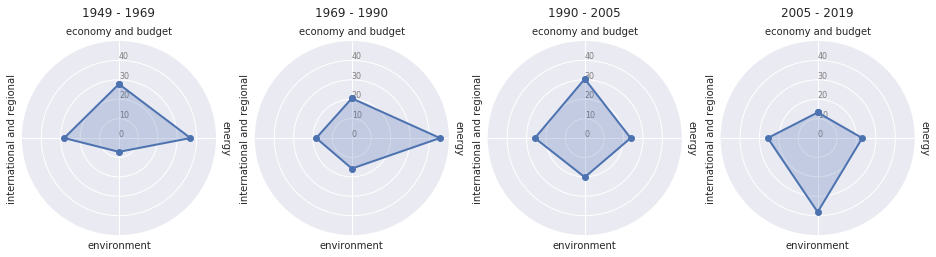

In [29]:
new_labels = False
threshold0 = False

period_sets = [[1,2,3,4,5], [6,7,8,9,10,11], [12, 13, 14, 15], [16, 17, 18, 19]]

classes = ["economy and budget", "energy", "environment", "international and regional"]

subplot_labels = ["1949 - 1969", "1969 - 1990", "1990 - 2005", "2005 - 2019"]

fig, axs = plt.subplots(1, len(period_sets), subplot_kw=dict(polar=True), figsize=(4*len(period_sets),4))

for i, periods in enumerate(period_sets):

    corr, pvalues = corr_topics(run_id,
                       period_list=periods,
                       filter_occurrence_no=None,
                       method=correlation_method)

    if wo_procedural:
        topic_dir = "plots/topic_analysis_{}/".format(run_id)
        topic_classification = pd.read_csv(topic_dir + '0_topic_list_run{}_labeled.csv'.format(run_id), index_col=0)
        procedural_topic_ids = topic_classification[topic_classification['classification'] == 'procedural and general politics'].index
        procedural_topic_ids

        corr = corr.drop(procedural_topic_ids, axis=0)
        corr = corr.drop(procedural_topic_ids, axis=1)
    
    # set diagonal elements to zero
    corr.values[[np.arange(corr.shape[0])]*2] = 0
    #show_matrix(corr)

    for cl in classes:
        topic_info = topic_classification[topic_classification['classification'] == cl]
        topic_labels = topic_info['label'].values
        topic_ids = topic_info.index
        
        centrality_sums.loc[cl, 'mean sum'] = corr[topic_ids].sum().mean()
        centrality_sums.loc[cl, 'total sum'] = corr[topic_ids].sum().sum()

    for cm in centrality_measures:
        centrality_sums['pct ' + cm] = 100 * centrality_sums[cm] / centrality_sums[cm].sum()
        
    # print(centrality_sums)
    spider_graph(centrality_sums['pct mean sum'].values, classes, ax=axs[i],
                 title=subplot_labels[i], ymax=50)

fig.savefig(os.path.join(save_dir, "graph_run_{}_aggregate_mean_sum_spiders_periods_{}".format(run_id, correlation_method)), bbox_inches="tight")